# Check Loglikelihood with Lapse Rate

2/2
After having checked correlation between LL and EM fits, it seemed that the sigma_output was not that great. Namely, LL required non-zero sigma_output, even though it's negatively correlated with good EM Kappa fits.

Perhaps that was due to a lack of support for outliers, so now we allow that with a non-zero lapse rate. This is quite drastic currently, might need to switch to log(lapse_rate) samples to make sure it's close to 0.

Performed by *generator_LLcheck_random_fitexperimentallt_sigmaxMratiosigmaoutput_121015.py*


In [200]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [201]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from experimentlauncher import ExperimentLauncher
from dataio import DataIO
import plots_experimental_data
import em_circularmixture_parametrickappa


# import matplotlib.animation as plt_anim
from mpl_toolkits.mplot3d import Axes3D

import re
import inspect
import imp

import utils
# import submitpbs
import load_experimental_data

In [202]:
import plotly
import plotly.plotly as py
import plotly.tools as tls
from plotly.graph_objs import * 

In [203]:
from IPython.html import widgets # Widget definitions
from IPython.display import display # Used to display widgets in the notebook
from IPython.html.widgets import interact
from plotly.widgets import GraphWidget 

In [204]:
%run reloader_LLlapse_random_fitexperimentallt_sigmaxMratiolapserate_131015.py

Reloader data generated from  generator_LLlapse_random_fitexperimentallt_sigmaxMratiolapserate_131015.py
Running  /nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/reloader_LLlapse_random_fitexperimentallt_sigmaxMratiolapserate_131015.py
Arguments: []

        Reload outputs run with the automatic parameter generator for PBS

        Should handle random sampling of the parameter space.
    
Reloader data generated from  generator_LLlapse_random_fitexperimentallt_sigmaxMratiolapserate_131015.py
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015/LLlapse_random_fitexperimentallt_bays09_sigmaxMratiolapserate_repetitions3_131015-launcher_do_fitexperiment_allmetrics-2a25bcad-3d59-4faa-bf4c-ae156c85fb92.npy
0.00%, -- left - 06.11 12:50
M 350.00, ratio_conj 0.10, sigmax 0.32, lapse_rate 0.23
/nfs/data3/lmatthey/visual_working_mem/fitexperiment_allt_new_10_2015/LLlapse_rando

In [205]:
#### SETUP
#
plots_bestfits = True
plots_scatter3d = False

savefigs = True

# dataio = DataIO(output_folder=generator_module.pbs_submission_infos['simul_out_dir'] + '/outputs/', label='global_' + dataset_infos['save_output_filename'])

#
#### /SETUP

In [206]:
# Extract data
result_ll_sum_flat = np.array(data_pbs.dict_arrays['result_ll_sum']['results_flat'])
result_ll90_sum_flat = np.array(data_pbs.dict_arrays['result_ll90_sum']['results_flat'])
result_bic_flat = np.array(data_pbs.dict_arrays['result_bic']['results_flat'])
result_precision_flat = np.array(data_pbs.dict_arrays['result_precision']['results_flat'])
result_em_fits_flat = np.array(data_pbs.dict_arrays['result_em_fits']['results_flat'])
result_emfit_mse_flat = np.array(data_pbs.dict_arrays['result_emfit_mse']['results_flat'])
result_emfit_mixt_kl_flat = np.array(data_pbs.dict_arrays['result_emfit_mixt_kl']['results_flat'])
result_fi_theo_flat = np.array(data_pbs.dict_arrays['result_fi_theo']['results_flat'])
result_fi_theocov_flat = np.array(data_pbs.dict_arrays['result_fi_theocov']['results_flat'])

result_parameters_flat = np.array(data_pbs.dict_arrays['result_ll_sum']['parameters_flat'])
all_repeats_completed = data_pbs.dict_arrays['result_ll_sum']['repeats_completed']

all_args_arr = np.array(data_pbs.loaded_data['args_list'])

M_space = data_pbs.loaded_data['parameters_uniques']['M']
ratio_conj_space = data_pbs.loaded_data['parameters_uniques']['ratio_conj']
sigmax_space = data_pbs.loaded_data['parameters_uniques']['sigmax']
lapserate_space = data_pbs.loaded_data['parameters_uniques']['lapse_rate']

num_repetitions = generator_module.num_repetitions
parameter_names_sorted = data_pbs.dataset_infos['parameters']

In [207]:
def str_best_params(best_i, result_dist_to_use):
    return '[{:3d}] '.format(best_ind) + ' '.join(["%s %.4f" % (parameter_names_sorted[param_i], result_parameters_flat[best_i, param_i]) 
                     for param_i in xrange(len(parameter_names_sorted))]) + ' >> %f' % result_dist_to_use[best_i]


In [208]:
def sort_df_best_params(df_to_use, metric, nb_params):
    return df_to_use.sort(metric)[:nb_params]

def print_str_best_params_df(df_to_use, metric, nb_params):
    df_sorted = sort_df_best_params(df_to_use, metric, nb_params)
    
    metric_space = ['dist_emfit_mse', 'dist_emfit_kl', 'dist_nll', 'dist_nll90', 'dist_bic']
    
    print 'Best for %s' % metric
    print '[  i ] ' + ' '.join(["%s" % param for param in parameter_names_sorted]) + \
    ' >> ' + ' '.join(["%s" % metric for metric in metric_space])
    
    for row_i, row in df_sorted.iterrows():
        print "[{:4d}] ".format(row_i) + \
        ' '.join(["%.4f" % (row[param]) for param in parameter_names_sorted]) + \
        ' >> ' + ' '.join(["%.4f" % row[curr_metric] for curr_metric in metric_space])


In [209]:
# Reload experimental data
experiment_id = all_args_arr[0]['experiment_id']
data_groundtruth = load_experimental_data.load_data(experiment_id=experiment_id)
T_space = data_groundtruth['data_to_fit']['n_items']

reloaded mixture model from cache /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/experimental_data/Bays2009/em_bays_allitems.pickle
reloaded collapsed mixture model from cache /nfs/nhome/live/lmatthey/Dropbox/UCL/1-phd/Work/Visual_working_memory/experimental_data/Bays2009/collapsed_em_bays.pickle


In [210]:
## Filter everything with repeats_completed == num_repet
filter_data = all_repeats_completed == num_repetitions - 1

result_parameters_flat = result_parameters_flat[filter_data]
all_args_arr = all_args_arr[filter_data]
all_repeats_completed = all_repeats_completed[filter_data]

print "Size post-filter: ", result_parameters_flat.shape[0]


Size post-filter:  1316


In [211]:
# Compute lots of averages over the repetitions
result_ll_sum_avg = utils.nanmean(result_ll_sum_flat, axis=-1)
result_ll90_sum_avg = utils.nanmean(result_ll90_sum_flat, axis=-1)
result_bic_avg = utils.nanmean(result_bic_flat, axis=-1)
result_em_fits_avg = utils.nanmean(result_em_fits_flat, axis=-1)
result_emfit_mse_avg = utils.nanmean(result_emfit_mse_flat, axis=-1)
result_emfit_mixt_kl_avg = utils.nanmean(result_emfit_mixt_kl_flat, axis=-1)

# Compute best results
result_dist_emfit_mse = np.nansum(np.nansum(result_emfit_mse_avg, axis=-1), axis=-1)
result_dist_emfit_kl = np.nansum(result_emfit_mixt_kl_avg, axis=-1)
result_dist_nll = np.nansum(-result_ll_sum_avg, axis=-1)
result_dist_nll90 = np.nansum(-result_ll90_sum_avg, axis=-1)
result_dist_bic = np.nansum(result_bic_avg, axis=-1)

## -> Pandas now

In [212]:
df_all_fits = pd.DataFrame.from_items([('M', result_parameters_flat[:, 0]),
                             ('ratio_conj', result_parameters_flat[:, 1]),
                             ('sigmax', result_parameters_flat[:, 2]),
                             ('lapse_rate', result_parameters_flat[:, 3]),
                             ('dist_bic', result_dist_bic),
                             ('dist_emfit_mse', result_dist_emfit_mse),
                             ('dist_emfit_kl', result_dist_emfit_kl),
                             ('dist_nll', result_dist_nll),
                             ('dist_nll90', result_dist_nll90),
                            ])
df_all_fits = df_all_fits.assign(dist_emfit_mse_log = lambda x: np.log(x['dist_emfit_mse']),
                                   dist_nll_log = lambda x: np.log(x['dist_nll'])
                                  )

In [213]:
# Filter rows where LL > cutoff value and remove lapse_rate > cutoff
LL_max_cutoff = 3500
LL_min_cutoff = 700
lapserate_cutoff = 0.5
sigmax_min_cutoff = 0.05

df_best_fits = df_all_fits[df_all_fits.dist_nll < LL_max_cutoff]
df_best_fits = df_best_fits[df_best_fits.dist_nll > LL_min_cutoff]
df_best_fits = df_best_fits[df_best_fits.lapse_rate < lapserate_cutoff]
df_best_fits = df_best_fits[df_best_fits.sigmax > sigmax_min_cutoff]

In [214]:
## Correlations
df_best_fits.corr()

,M,ratio_conj,sigmax,lapse_rate,dist_bic,dist_emfit_mse,dist_emfit_kl,dist_nll,dist_nll90,dist_emfit_mse_log,dist_nll_log
M,1.000000,0.335195,0.160320,0.167508,0.238605,0.145206,-0.018628,0.238605,0.123865,0.234092,0.228691
ratio_conj,0.335195,1.000000,0.096247,-0.076089,-0.328399,-0.176111,-0.395396,-0.328399,-0.390306,-0.417825,-0.303505
sigmax,0.160320,0.096247,1.000000,-0.082767,0.347603,-0.164146,0.580727,0.347603,0.397747,-0.390922,0.365793
lapse_rate,0.167508,-0.076089,-0.082767,1.000000,-0.044098,0.067842,0.269749,-0.044098,0.165215,0.318394,-0.049969
dist_bic,0.238605,-0.328399,0.347603,-0.044098,1.000000,-0.235315,0.498309,1.000000,0.941209,0.331558,0.994630
dist_emfit_mse,0.145206,-0.176111,-0.164146,0.067842,-0.235315,1.000000,-0.017498,-0.235315,-0.224121,0.395588,-0.313120
dist_emfit_kl,-0.018628,-0.395396,0.580727,0.269749,0.498309,-0.017498,1.000000,0.498309,0.644170,0.036233,0.490578
dist_nll,0.238605,-0.328399,0.347603,-0.044098,1.000000,-0.235315,0.498309,1.000000,0.941209,0.331558,0.994630
dist_nll90,0.123865,-0.390306,0.397747,0.165215,0.941209,-0.224121,0.644170,0.941209,1.000000,0.336944,0.937811
dist_emfit_mse_log,0.234092,-0.417825,-0.390922,0.318394,0.331558,0.395588,0.036233,0.331558,0.336944,1.000000,0.286209


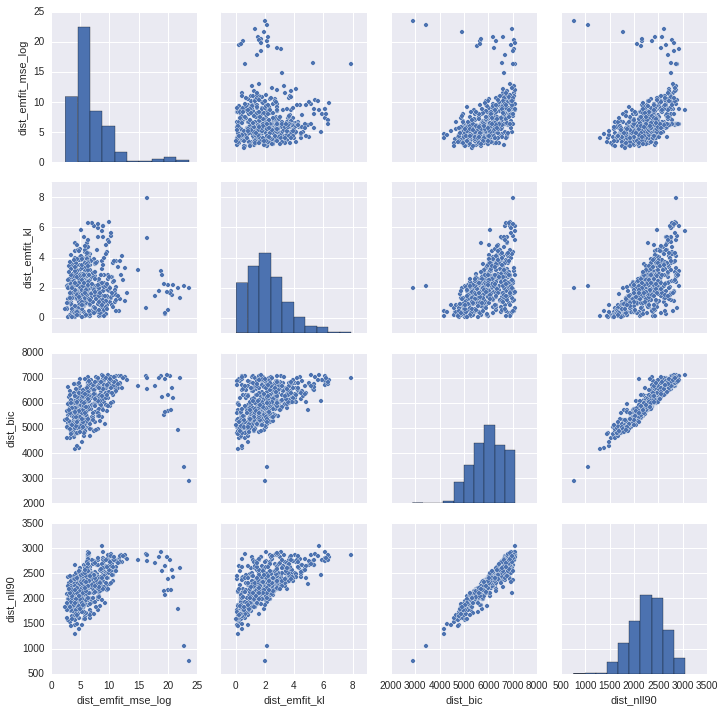

In [215]:
# Cross-correlation plots
sns.pairplot(df_best_fits,
             x_vars=['dist_emfit_mse_log', 'dist_emfit_kl', 'dist_bic', 'dist_nll90'],
             y_vars=['dist_emfit_mse_log', 'dist_emfit_kl', 'dist_bic', 'dist_nll90']
            )

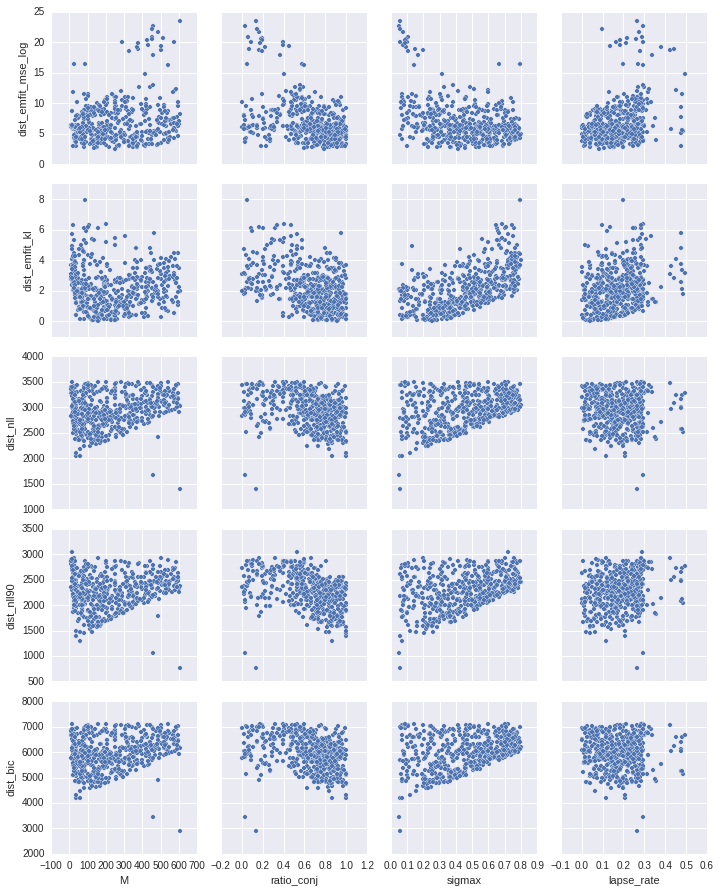

In [216]:
# Check parameters effects
sns.pairplot(df_best_fits,
             x_vars=['M', 'ratio_conj', 'sigmax', 'lapse_rate'],
             y_vars=['dist_emfit_mse_log', 'dist_emfit_kl', 'dist_nll', 'dist_nll90', 'dist_bic']
            )

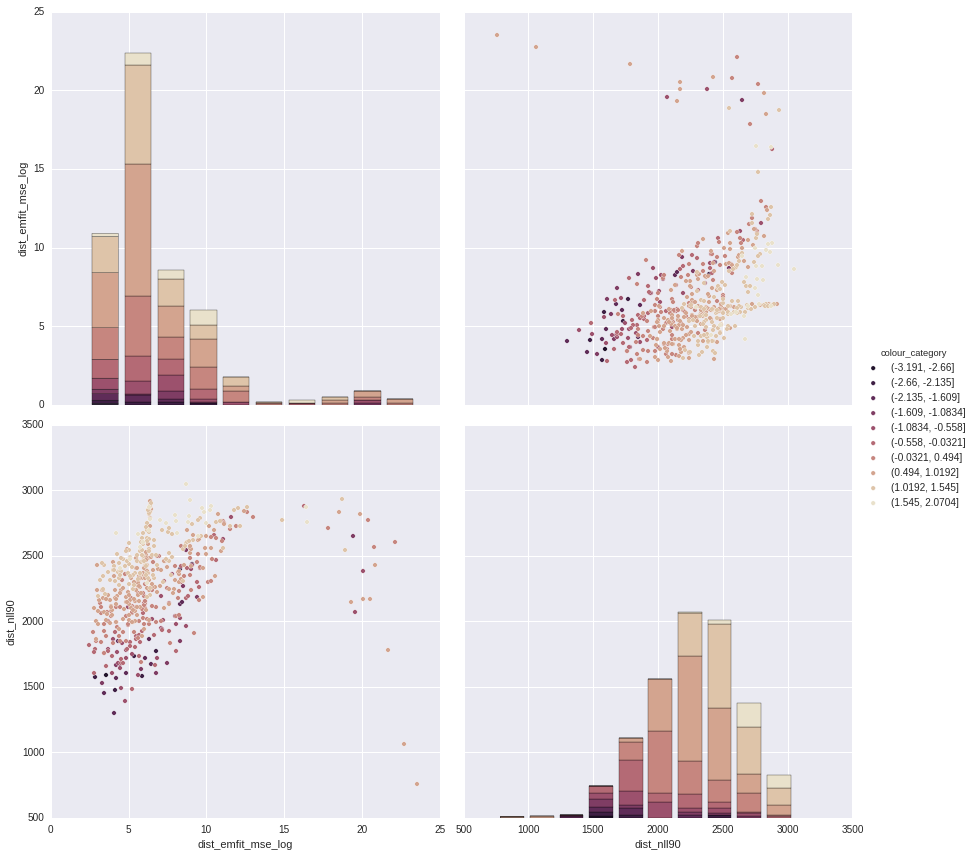

In [217]:
# Color code for Colour KL fit this time 
mycubehelix = sns.cubehelix_palette(dark=0.15, n_colors=10, start=0, rot=0.5, gamma=1.2, hue=0.9, light=0.9, reverse=True)
sns.pairplot(df_best_fits.assign(colour_category=pd.cut(np.log(df_best_fits['dist_emfit_kl']), bins=10)),
             hue='colour_category',
             palette=mycubehelix,
             vars=['dist_emfit_mse_log', 'dist_nll90'],
             size = 6
            )

## Plotly Scatter3d

In [231]:
result_to_color = np.array(df_best_fits.dist_nll90)

col_min = np.min(result_to_color)
col_max = np.max(result_to_color)

text = ['> %s' % (x) for x in result_to_color]

trace1 = Scatter3d(
        x= df_best_fits.M,
        y= df_best_fits.ratio_conj,
        z= df_best_fits.sigmax,
        text= text,
        mode= 'markers',
        marker= Marker(
            color = result_to_color,
            size = 7,
            colorscale='Bluered',
            cmin=col_min,
            cmax=col_max,
            cauto=False
        )
    )
data = Data([trace1])
layout = Layout(
    title='Landscape for NLL90',
    scene=Scene(
        xaxis=XAxis(
            title=df_best_fits.columns.values[0],
        ),
        yaxis=YAxis(
            title=df_best_fits.columns.values[1],
        ),
        zaxis=ZAxis(
            title=df_best_fits.columns.values[2],
        )
    )
)
fig = Figure(data=data, layout=layout)
scatter3d_url = py.plot(fig)

In [232]:
dropdown_space = parameter_names_sorted
dropdown_default = 'lapse_rate'
metric_color_space = ['dist_emfit_mse', 'dist_emfit_kl', 'dist_nll', 'dist_nll90', 'dist_bic']
metric_color_default = 'dist_nll90'

g = GraphWidget(scatter3d_url)

class shifter:
    def __init__(self):
        self.slider_index = 0
        self.marker_size = 8
        self.filter_results = slice(None, None)
        self.metric_color = metric_color_default
        self.dropdown_value = dropdown_default
        
        self.change_color_source(metric_color_default)
        self.change_dropdown_value(dropdown_default)
    
    def change_dropdown_value(self, new_value):
        self.dropdown_value = new_value
        
        # Update the axes
        self.axes_parameters = dropdown_space[:]
        self.axes_parameters.remove(self.dropdown_value)
        
        # Update the grid of the dropdown parameter
        self.dropparam_gridified, self.dropparam_gridspace, self.dropparam_midspace = utils.gridify(df_best_fits[self.dropdown_value], bins=10)
        
        
    
    def change_color_source(self, new_value):
        self.metric_color = new_value
        self.result_to_color = np.array(df_best_fits[self.metric_color])
        self.result_to_color[self.result_to_color > 2*np.median(self.result_to_color)] = np.median(self.result_to_color)
        self.col_min = np.min(self.result_to_color)
        self.col_max = np.max(self.result_to_color)
    
    def on_color_source_change(self, name, old_value, new_value):
        self.change_color_source(new_value)
        self.replot()
    
    def on_dropdown_change(self, name, old_value, new_value):
        self.change_dropdown_value(new_value)
        p_slider.description='%s [all]' % self.dropdown_value
        self.replot()
    
    def on_slider_change(self, name, old_value, new_value):
        self.slider_index = new_value
        
        if self.slider_index > -1:
            self.filter_results = self.dropparam_gridified[self.slider_index]
            self.marker_size = 6
            p_slider.description='%s [%f]' % (self.dropdown_value, self.dropparam_gridspace[self.slider_index])
        else:
            self.filter_results = slice(None, None)
            self.marker_size = 6
            p_slider.description='%s [all]' % self.dropdown_value
        
        self.text = ['%s > %s' % (x[0], x[1]) for x in 
                     zip(df_best_fits[self.dropdown_value][self.filter_results], self.result_to_color[self.filter_results])]
        
        self.replot()
        
    def replot(self):
        self.text = ['%s > %s' % (x[0], x[1]) for x in 
                     zip(df_best_fits[self.dropdown_value][self.filter_results], self.result_to_color[self.filter_results])]
        
        new_trace = Scatter3d(
            x= df_best_fits[self.axes_parameters[0]][self.filter_results],
            y= df_best_fits[self.axes_parameters[1]][self.filter_results],
            z= df_best_fits[self.axes_parameters[2]][self.filter_results],
            text= self.text,
            mode= 'markers',
            marker= Marker(
                color = self.result_to_color[self.filter_results],
                size = self.marker_size,
                colorscale='Bluered',
                cmin=self.col_min,
                cmax=self.col_max,
                cauto=False
            )
        )
        g.restyle({'x': [[]], 'y': [[]], 'z': [[]], 'marker':None, })
        g.relayout({'title' : "Landscape for %s" % self.metric_color,
                    'scene.xaxis.title': self.axes_parameters[0],
                    'scene.yaxis.title': self.axes_parameters[1],
                    'scene.zaxis.title': self.axes_parameters[2],
                    })
        g.add_traces(new_trace)

p_state = shifter()
p_metric_drop = widgets.Dropdown(description='Metric for color', options=metric_color_space, value=metric_color_default)
p_variable_drop = widgets.Dropdown(description='Variable to slide', options=dropdown_space, value=dropdown_default)
p_slider = widgets.IntSlider(min=-1, max=p_state.dropparam_midspace.size-1, value=-1)
p_slider.description='%s [all]' % p_state.dropdown_value

p_slider.on_trait_change(p_state.on_slider_change, 'value')
p_variable_drop.on_trait_change(p_state.on_dropdown_change, 'value')
p_metric_drop.on_trait_change(p_state.on_color_source_change, 'value')

p_state.replot()

In [233]:
display(p_metric_drop)
display(p_variable_drop)
display(p_slider)
display(g)

## Look at best parameters


In [221]:
max_best_params = 10

print_str_best_params_df(df_best_fits, 'dist_emfit_mse', max_best_params)
print

print_str_best_params_df(df_best_fits, 'dist_emfit_kl', max_best_params)
print

print_str_best_params_df(df_best_fits, 'dist_nll', max_best_params)
print

print_str_best_params_df(df_best_fits, 'dist_nll90', max_best_params)
print

print_str_best_params_df(df_best_fits, 'dist_bic', max_best_params)

Best for dist_emfit_mse
[  i ] M ratio_conj sigmax lapse_rate >> dist_emfit_mse dist_emfit_kl dist_nll dist_nll90 dist_bic
[1062] 250.0000 0.7840 0.4136 0.0844 >> 11.3789 0.5753 2610.1633 1820.6141 5319.7604
[1218] 135.0000 0.6000 0.4544 0.1086 >> 14.9553 1.0016 2628.8218 1918.6340 5357.0774
[1016] 148.0000 0.6757 0.3664 0.1350 >> 15.7151 0.5916 2464.2545 1762.4920 5027.9426
[ 674] 79.0000 0.6203 0.2311 0.1997 >> 16.1153 0.6476 2244.6542 1608.3571 4588.7421
[ 336] 371.0000 0.7790 0.5405 0.1555 >> 16.1361 2.1321 2798.0557 2098.2079 5695.5451
[ 604] 149.0000 0.8121 0.2842 0.0377 >> 16.8296 0.0828 2473.8800 1571.5800 5047.1938
[ 981] 216.0000 0.9074 0.3717 0.1965 >> 17.3301 0.9656 2449.4080 1788.9282 4998.2498
[  86] 347.0000 0.8329 0.5213 0.1481 >> 17.6106 2.1620 2701.6823 1998.7124 5502.7984
[ 561] 22.0000 0.1818 0.1001 0.1298 >> 18.4369 2.0475 2493.8558 1865.0560 5087.1454
[ 362] 270.0000 0.9481 0.4550 0.1542 >> 18.7661 1.2725 2543.1322 1851.1585 5185.6981

Best for dist_emfit_kl
[  i 

WARNING, THIS IS FITTED ON FULL DATA, NOT 500 FIRST SAMPLES AS OUR MODEL
Collapsed Kappa, slightly better LL, again fitted on full data!


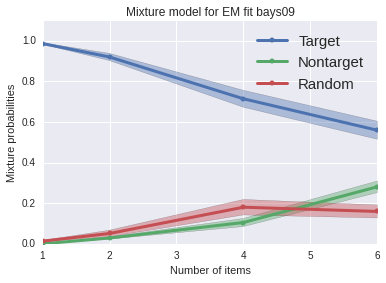

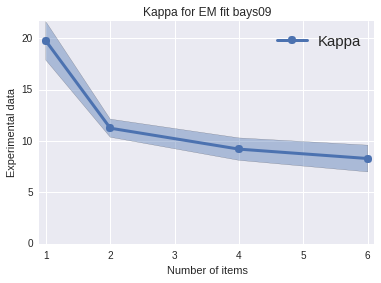

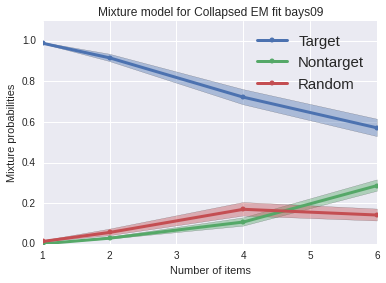

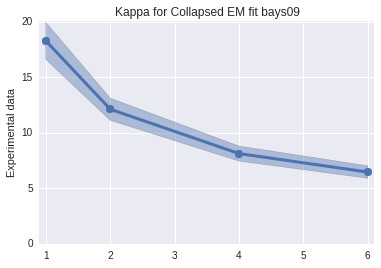

In [222]:
# Ground truth
print 'WARNING, THIS IS FITTED ON FULL DATA, NOT 500 FIRST SAMPLES AS OUR MODEL'
plots_experimental_data.plots_bays2009(data_groundtruth)

# Collapsed Kappa for comparison
print 'Collapsed Kappa, slightly better LL, again fitted on full data!'
plots_experimental_data.plots_collapsed_em_mixtures(data_groundtruth)

# Plot best
def plot_modelfits(T_space, curr_result_emfits_t, labelplot='', dataio=None):
    curr_result_avg = np.mean(curr_result_emfits_t, axis=-1)
    curr_result_std = np.std(curr_result_emfits_t, axis=-1)
    
    f, ax = plt.subplots()    
    ax = plots_experimental_data.plot_kappa_mean_error(T_space, curr_result_avg[..., 0], curr_result_std[..., 0], title=labelplot, ax=ax, label='Kappa', xlabel='Number of items')

    if dataio is not None:
        dataio.save_current_figure('bestfit_%s_kappa_{label}_{unique_id}.pdf' % labelplot)

    f, ax = plt.subplots()
    ax = plots_experimental_data.plot_emmixture_mean_error(T_space, curr_result_avg[..., 1], curr_result_std[..., 1], title=labelplot, label='Target', xlabel='Number of items', ax=ax)
    ax = plots_experimental_data.plot_emmixture_mean_error(T_space, curr_result_avg[..., 2], curr_result_std[..., 2], title=labelplot, label='Nontarget', xlabel='Number of items', ax=ax)
    ax = plots_experimental_data.plot_emmixture_mean_error(T_space, curr_result_avg[..., 3], curr_result_std[..., 3], title=labelplot, label='Random', xlabel='Number of items', ax=ax)
    
    if dataio is not None:
        dataio.save_current_figure('bestfit_%s_mixttarget_{label}_{unique_id}.pdf' % labelplot)

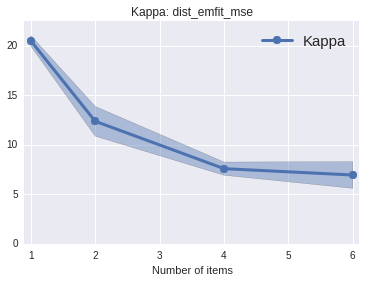

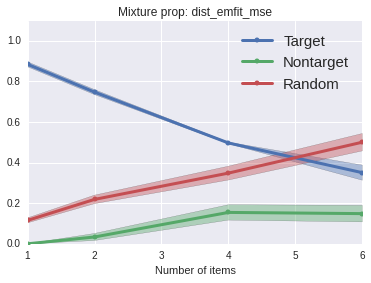

In [223]:
# Best fit for EM MSE
@interact(best_index=(0, 9, 1), metric=['dist_emfit_mse', 'dist_emfit_kl', 'dist_nll', 'dist_nll90'])
def plot_model_fit(metric='dist_emfit_mse', best_index=0):
    df_sorted = sort_df_best_params(df_best_fits, metric, max_best_params)
    plot_modelfits(T_space, result_em_fits_flat[df_sorted.index[best_index]], metric)

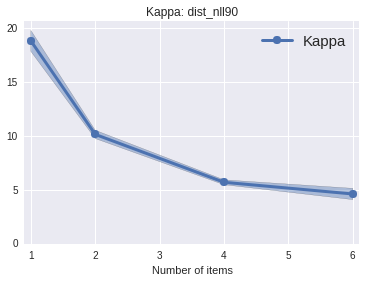

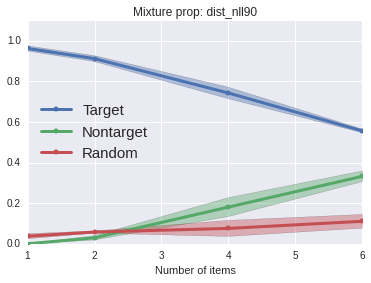

In [228]:
# Best fit for NLL90
@interact(best_index=(0, 9, 1), metric=['dist_emfit_mse', 'dist_emfit_kl', 'dist_nll', 'dist_nll90'])
def plot_model_fit(metric='dist_nll90', best_index=0):
    df_sorted = sort_df_best_params(df_best_fits, metric, max_best_params)
    plot_modelfits(T_space, result_em_fits_flat[df_sorted.index[best_index]], metric)

In [225]:
# Compute EM Mixture fits on subset of data used by our model, to compare LL and BIC properly
dataset = data_groundtruth
responses_subset = np.empty((T_space.size, 500))
targets_subset = np.empty((T_space.size, 500))
nontargets_subset = np.empty((T_space.size, 500, T_space[-1] - 1))

for T_i, T in enumerate(T_space):
    responses_subset[T_i] = dataset['data_to_fit'][T]['response'][:500]
    targets_subset[T_i] = dataset['data_to_fit'][T]['item_features'][:500, 0, 0]
    nontargets_subset[T_i, :, :(T-1)] = dataset['data_to_fit'][T]['item_features'][:500, 1:T, 0]

params_fit = em_circularmixture_parametrickappa.fit(T_space,
        responses_subset, targets_subset, nontargets_subset, debug=False)

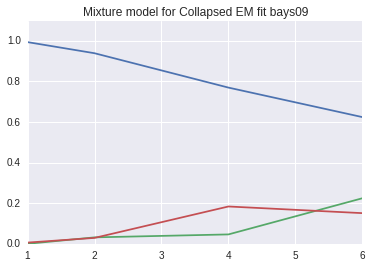

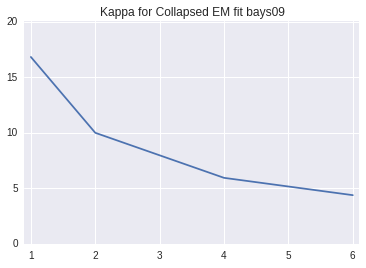

In [226]:
f, ax = plt.subplots()

ax.plot(T_space, params_fit['mixt_target'])
ax.plot(T_space, params_fit['mixt_nontargets'])
ax.plot(T_space, params_fit['mixt_random'])

ax.legend(prop={'size':15})

ax.set_title('Mixture model for Collapsed EM fit %s' % dataset['name'])
ax.set_xlim([1.0, T_space.max()])
ax.set_ylim([0.0, 1.1])
ax.set_xticks(range(1, T_space.max()+1))
ax.set_xticklabels(range(1, T_space.max()+1))

f.canvas.draw()

# Kappa
f, ax = plt.subplots()

ax.plot(T_space, params_fit['kappa'])

ax.legend(prop={'size':15})
ax.set_title('Kappa for Collapsed EM fit %s' % dataset['name'])
ax.set_xlim([0.9, T_space.max()+0.1])
ax.set_ylim([0.0, np.max(dataset['collapsed_em_fits']['mean']['kappa'])*1.1])
ax.set_xticks(range(1, T_space.max()+1))
ax.set_xticklabels(range(1, T_space.max()+1))
ax.get_figure().canvas.draw()

In [227]:
# BIC now
print 'EM Model NLL: ', -params_fit['train_LL']
print 'EM Model BIC: ', params_fit['bic']
print

# Our Model BIC:
print 'Model BIC is around 4000'
print 'Our model BIC, for good fit, best_index 4:'
print '[ 907] 81.0000 1.0000 0.2028 0.0382 >> 29.4631 0.1496 2332.5732 1449.1216 4764.5802'

EM Model NLL:  1558.72195598
EM Model BIC:  3207.22102003

Model BIC is around 4000
Our model BIC, for good fit, best_index 4:
[ 907] 81.0000 1.0000 0.2028 0.0382 >> 29.4631 0.1496 2332.5732 1449.1216 4764.5802


# Observations

So this is a better situation than with sigma_output.

There is some overlap between the best parameters, and apart from some specific sub-parameters regions that have high LL but low emfits (it's a valid/wrong strategy :P Super extra precise on a few points, random on others), most things are compatible.

More precisely:
* LL90 is well correlated with emfit_kl, at 0.8. Good points for LL90 usually have good emfit_kl scores.
* LL90 is kinda correlated with emfit_mse, 0.6. But as always, getting this properly is quite hard. I'm starting CMA/ES runs now and we will see, but this may be problematic. 
* Looking at the 3D views, we see that best parameters for emfit_mse and emfit_kl do not really overlap well. And squinting a bit, it does nearly look like LL90 is going for the best of both, although a bit more prefering emfit_kl. So that's great in my opinion, at least it's not doing something completely stupid!

Choosing among the top-10 LL90 values get some nice and acceptable fits.

Using LL instead shows that the lapse rate is always higher, so some bad trials are really driving the whole loglikelihood down dramatically.